This notebook shows an example of how to conduct a point-source analysis.
The core of the analysis is a binned poisson likelihood evaluation using Asimov data.
The histograms of the analysis are the effective area, the energy resolution, the angular resolution and the atmospheric background model.
Core functions of the PLEnuM software are used in this example.

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preparations

In [20]:
# # need to run once in the beginning to prepare all ingredients for the analysis
# # this might take several minutes

# # run these only if you haven't done so before
# # load IceCube's effective area and rotate it to approximate other detectors
# %run ../../core/aeff_calculations.py

# # calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# # run these every time there are updates to resolution, binning, or mephistograms
# # load and prepare the energy and angular resolutions
# %run ../../core/resolution.py

# # gather all ingredients and save them as unified 'mephistogram' data structure
# %run ../../core/prepare_histograms.py

# Imports

In [21]:
import pickle
from collections import namedtuple
from copy import copy
from os.path import join

import numpy as np
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
)
import mephisto
from matplotlib.colors import LogNorm
from scipy.optimize import fmin_l_bfgs_b
from scipy.stats import chi2, norm
from settings import *
from tools import array_source_interp
from likelihood import poisson_llh


# Default binning

In [22]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
502 -1.0 1.0


# Source parameters

In [23]:
# livetime of 10yrs in seconds and days
print(LIVETIME, LIVETIME / 24 / 3600)
# Normalization energy of power law (E/E_NORM)^GAMMA_ASTRO
print(E_NORM)  # in GeV
# Source flux spectral index
# see https://arxiv.org/abs/2111.10299?context=astro-ph
print(GAMMA_ASTRO)  # spectral index
print(PHI_ASTRO)  # neutrinos * (E/E_NORM)^GAMMA_ASTRO / GeV / cm^2 / s / sr
print(BASEPATH)
print(LOCALPATH)


308975040.0 3576.1
100000.0
2.37
1.44e-18
/home/hpc/capn/capn102h/repos/Plenum
/home/hpc/capn/capn102h/repos/Plenum/local


# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

dict_keys(['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD', 'TRIDENT', 'HUNT', 'NEON', 'Horizon', 'Gen-2'])
Mephistogram with 2 dimensions and shape (501, 140). Axis names are ('sin(dec)', 'log(E/GeV)').
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [19.17       19.17       20.60946965 ... 18.65898399 17.14947146
  11.96794101]
 [19.17       19.17       20.60946965 ... 18.65898399 17.14947146
  11.96794101]
 [19.17       19.17       20.60946965 ... 18.65898399 17.14947146
  11.96794101]]


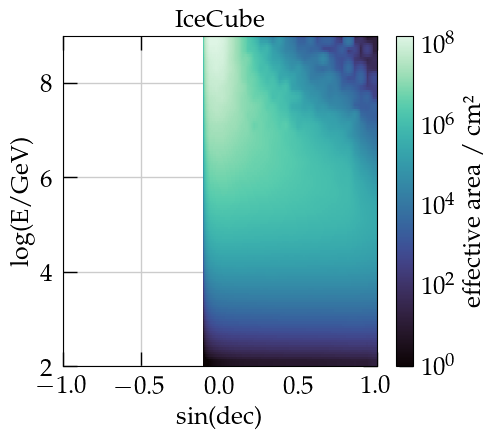

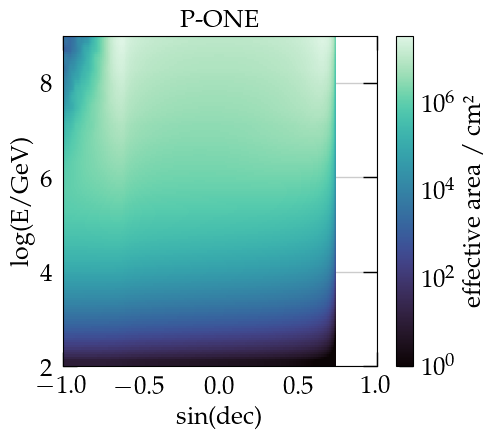

In [24]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
print(aeff_2d.keys())
print(aeff_2d["IceCube"])  # mephistogram data structure for histograms+binning

# plot the effective area
for key in ["IceCube", "P-ONE"]:
    mephisto.plot_mephistogram(aeff_2d[key], norm=LogNorm(vmin=1))
    cb = plt.gca().collections[0].colorbar
    cb.set_label("effective area / cm²")
    plt.title(key)


# Background

Elementary arithmetic possible.
True


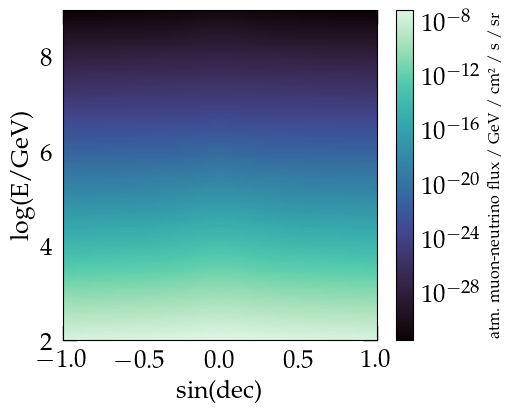

In [25]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histograms are matching, i.e. have the same binning
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

# visualization of bckg flux
mephisto.plot_mephistogram(bckg_histo["IceCube"], norm=LogNorm())
cb = plt.gca().collections[0].colorbar
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


# Energy smearing

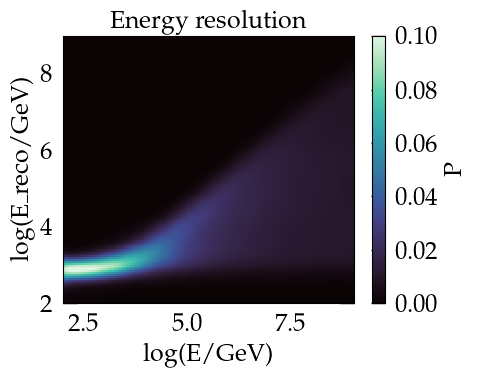

In [26]:
# energy smearing matrix
with open(join(LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)
cmap = "mako"
f, ax = mephisto.plot_mephistogram(baseline_eres, cmap=cmap, vmax=0.1, vmin=0)
cb = plt.gca().collections[0].colorbar
cb.set_label("P")
ax.set_title("Energy resolution")
f.tight_layout()
#f.savefig("../../plots/eres-icecube.png")

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [27]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

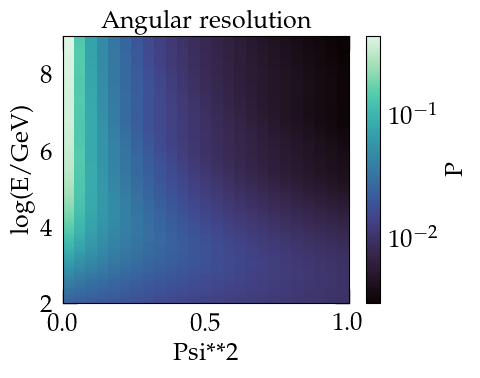

In [28]:
f, ax = mephisto.plot_mephistogram(e_psi2_grid, norm=LogNorm(vmin=3E-3), cmap=cmap)
cb = plt.gca().collections[0].colorbar
cb.set_label("P")
ax.set_xlim(0, 1)
ax.set_title("Angular resolution")
f.tight_layout()
#f.savefig("../../plots/psi2res-icecube.png")

# Source flux definition
$N_{\nu} = T_{\rm live} \cdot \int_{\Delta \Omega} d \Omega \, d E \, \int_{E_{\min}}^{E_{\max}} dE \, A_{\rm eff} \left( E, \sin(\delta)\right) \cdot \frac{d \Phi}{d E} $

Approximate the integral with a finite-binning approach:

aeff_factor =
$ 2\pi \cdot \Delta \sin (\delta) \, \Delta E \cdot A_{\rm eff} \left( E, \sin(\delta)\right) $ 

($2\pi = \int_0^{2\pi} d\phi$; $d \Omega = d \phi \cdot d \sin(\delta)$)

In [ ]:
# we base the flux models on named-tuples
from fluxes import PL_flux
ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")


In [30]:
# ngc1068 source config
ngc_src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
    dec=ngc1068.dec.rad,
)
# corresponding bg config
ngc_bg_config = copy(ngc_src_config)
ngc_bg_config["dpsi_max"] = delta_psi_max
ngc_bg_config["grid_2d"] = bckg_psi2_grid



## Check event numbers

In [31]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s)) 


ngc 1068: 98.2082534964597


# DEMO: differential sensitivity

In [44]:
from likelihood import ps_llh_single
import settings as st

## Fit one bin

In [77]:
from mephisto import like

In [79]:
ident = "IceCube"

aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal_full = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

_slicer = 10  # ten parts of the energy binning per differential-bin
_num = 3
_idx_select = np.arange(_num * _slicer, (_num + 1) * _slicer)
aeff_factor_signal = like(aeff_factor_signal_full)
aeff_factor_signal.histo[:, _idx_select] = aeff_factor_signal_full.histo[:, _idx_select]

# asimov data
k_b = atmo_background(
    aeff_factor=aeff_factor_bckg,
    bckg_vals=array_source_interp(ngc_src_config["dec"], bckg_histo["IceCube"], sindec_mids, axis=1),
    energy_resolution=baseline_eres,
)
# power law
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=emids,
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,  # powerlaw
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))
print("Signal:", np.sum(k_s))


dct = dict(
    aeff_factor_b=k_b,
    fixed_BG=True, bckg_flux=None, # pre-computed BG
    aeff_factor_s=aeff_factor_signal,
    k_i=k_i,
    e_0=ngc_flux.E0,
    phi_0=ngc_flux.norm,
    energy_resolution=baseline_eres,
    shape="powerlaw"
)

# fix signal normalization to 0
local_llh = lambda x: ps_llh_single((x[0], 0, 3), **dct)
global_llh = lambda x: ps_llh_single(x, **dct)

out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1,),
    approx_grad=True,
)
print("Atmo-only normalization:", out_bckg[0])

# this fit is not really needed, but good for crosschecking the code
out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1, 1, ngc_flux.gamma),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])
print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = norm.isf(pval)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)

Asimov data sum:
Background: 1488.281037312281
Signal: 15.058322928458338
Atmo-only normalization: [1.01011702]
Signal fit parameters: [1.  1.  3.2]
TS check: -306553.1232436568 (fit:  -306553.1232436568 )
-2 Delta LLH: 1.6094166137627326
P-VALUE: 0.447218358053018 SIGNIFICANCE: 0.13269232101172274


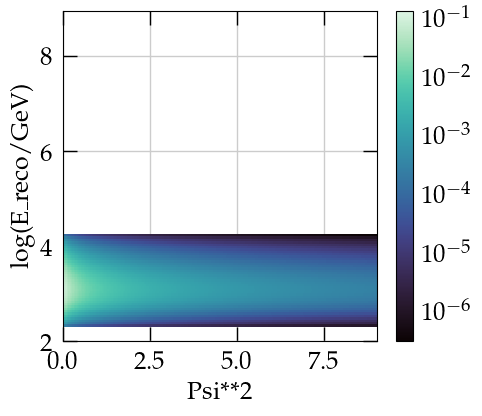

In [82]:
k_s.plot(norm=LogNorm())